In [1]:
import pandas as pd
import plotly as py
from plotly import tools
import plotly.graph_objs as go
#https://plot.ly/python/
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.definitions.instruments as definstruments

In [2]:
CandlestickGranularity = (definstruments.CandlestickGranularity().definitions.keys())

#initiating API connection and defining trade parameters
token_path = "C:\\Oanda\\Tradebot\\token.txt"
client = oandapyV20.API(access_token=open(token_path,'r').read(),environment="practice")
account_id = "101-002-9736246-001"

#defining strategy parameters
pairs = ['AUD_CAD','AUD_USD','CAD_CHF','CAD_HKD','CAD_SGD','EUR_AUD','EUR_CAD','EUR_GBP','EUR_USD','GBP_USD','NZD_CAD','USD_CAD','USD_CNH'] #currency pairs to be included in the strategy
#pairs = ['EUR_JPY','USD_JPY','AUD_JPY','AUD_USD','AUD_NZD','NZD_USD']
pos_size = 2000 #max capital allocated/position size for any currency pair
upward_dir = {}
dnward_dir = {}
for i in pairs:
    upward_dir[i] = False
    dnward_dir[i] = False

def candles(instrument):
    params = {"count": 1500,"granularity": list(CandlestickGranularity)[18]} #granularity is in 1 minute[4] 'M15'; it can be in seconds S5 - S30, minutes M1 - M30, hours H1 - H12, days D, weeks W or months M
    candles = instruments.InstrumentsCandles(instrument=pairs[0],params=params)
    client.request(candles)
    ohlc_dict = candles.response["candles"]
    ohlc = pd.DataFrame(ohlc_dict)
    ohlc_df = ohlc.mid.dropna().apply(pd.Series)
    ohlc_df["volume"] = ohlc["volume"]
    ohlc_df.index = ohlc["time"]
    ohlc_df = ohlc_df.apply(pd.to_numeric)
    return ohlc_df

In [3]:
df = candles('USD_CAD')

In [4]:
df['date'] = df.index

In [5]:
df.date = pd.to_datetime(df.date,format='%Y-%m-%d %H:%M:%S.%f')

In [6]:
#df = df.reset_index()

In [7]:
df.tail(1)

,o,h,l,c,volume,date
time,,,,,,
2020-03-16T21:00:00.000000000Z,0.85728,0.85868,0.8443,0.8521,314352,2020-03-16 21:00:00+00:00


In [8]:
df.columns= ['open','high','low','close','volume','date']

In [9]:
df = df.set_index(df.date)
df = df[['open','high','low','close','volume']]
df = df.drop_duplicates(keep=False)

ma= df.close.rolling(center=False,window=30).mean()

In [10]:
trace0 = go.Ohlc(x=df.index, open=df.open, high=df.high, low=df.low,close=df.close,name="Currency Quote")
trace1 = go.Scatter(x=df.index, y=ma)
trace2 = go.Bar(x=df.index, y=df.volume)

In [11]:
data = [trace0]

fig = tools.make_subplots(rows=2,cols=1,shared_xaxes=True)
fig.append_trace(trace0,1,1)
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,2,1)

C:\Users\gutia\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [12]:
#py.offline.plot(fig,filename='usdcad.html')

In [13]:
df.tail(5)


,open,high,low,close,volume
date,,,,,
2020-03-10 21:00:00+00:00,0.89280,0.89821,0.88941,0.89322,212103
2020-03-11 21:00:00+00:00,0.89322,0.89479,0.86596,0.86823,364370
2020-03-12 21:00:00+00:00,0.86823,0.88121,0.85199,0.85593,370961
2020-03-15 21:00:00+00:00,0.85361,0.86861,0.84335,0.85728,413186
2020-03-16 21:00:00+00:00,0.85728,0.85868,0.84430,0.85210,314352


In [14]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import joblib

import xgboost
from xgboost import XGBRegressor, DMatrix

In [15]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy version:1.18.1
Pandas version:1.0.1
MatlpotLib version:3.1.3
Seaborn version:0.10.0
Sci-Kit Learn version:0.22.1
XGBoost version:0.90


In [16]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

No handles with labels found to put in legend.


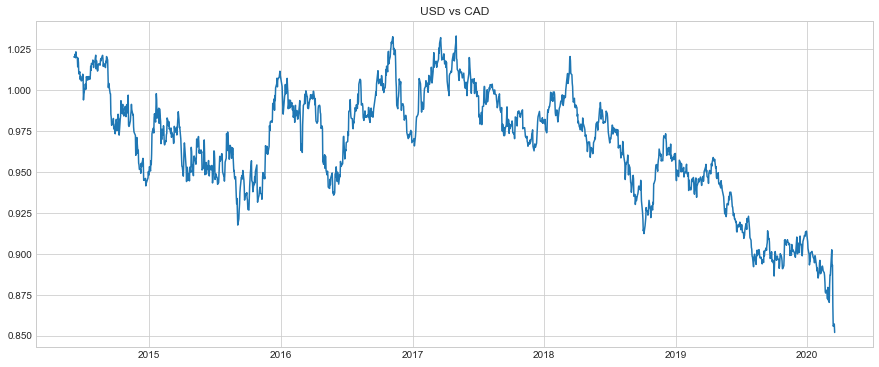

In [17]:
plt.figure(figsize=(15,6))
plt.plot(df.close)
plt.title('USD vs CAD')
plt.legend()
plt.show()

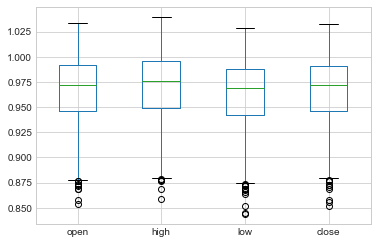

In [18]:
#box plot for open, high, low , close
df.drop('volume', axis=1).boxplot()

In [19]:
#removing outliers above
vol_cut_off = df.volume.std()*3 + df.volume.mean()
df.volume[df.volume > vol_cut_off] = vol_cut_off

In [20]:
#removing ouliers below
vol_cut_off =  df.volume.mean() - df.volume.std()*3
df.volume[df.volume < vol_cut_off] = vol_cut_off

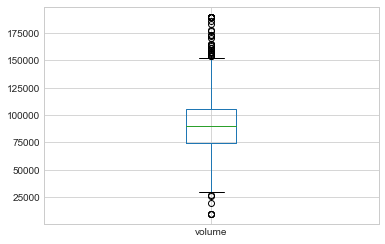

In [21]:
#boxplot for volume
df[['volume']].boxplot()

In [22]:
cad = df
del df

In [23]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_90'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(cad)

In [24]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
date,,,,,,,,,,,,,,,,,,,,,
2015-05-28 21:00:00+00:00,0.95119,0.96226,0.95125,0.96610,0.95069,121616.0,0.960052,0.960692,0.963269,0.982110,...,0.703891,-0.011668,-0.012571,-0.011647,-0.022856,-0.067640,-0.002515,-0.000350,-0.000264,0.95172
2015-05-31 21:00:00+00:00,0.95028,0.95119,0.95172,0.95738,0.94962,98788.0,0.958118,0.960554,0.962870,0.981838,...,0.704053,0.000494,-0.010058,-0.003038,-0.025736,-0.067179,-0.002007,-0.000397,-0.000262,0.95243
2015-06-01 21:00:00+00:00,0.95268,0.95028,0.95243,0.95592,0.95026,87377.0,0.955904,0.960456,0.962572,0.981562,...,0.705394,0.000746,-0.011489,-0.002169,-0.019337,-0.068072,-0.002297,-0.000293,-0.000266,0.96392
2015-06-02 21:00:00+00:00,0.96438,0.95268,0.96392,0.96597,0.95222,111455.0,0.956360,0.961224,0.962445,0.981340,...,0.703365,0.012064,0.002371,0.017019,-0.008190,-0.054721,0.000502,-0.000113,-0.000209,0.96960
2015-06-03 21:00:00+00:00,0.96966,0.96438,0.96960,0.97176,0.96330,106075.0,0.957784,0.961752,0.962376,0.981127,...,0.702810,0.005893,0.007398,0.011581,-0.004456,-0.052533,0.001506,-0.000053,-0.000200,0.96122


In [25]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,...,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000
mean,0.962715,0.962800,0.962786,0.966415,0.959200,93253.936073,0.962945,0.963462,0.964632,0.970061,...,0.910509,-0.000082,-0.000340,-0.001327,-0.003521,-0.014673,-0.000067,-0.000051,-0.000051,0.962706
std,0.036102,0.035979,0.036082,0.036199,0.035847,26405.001656,0.035636,0.034474,0.031668,0.022421,...,0.205623,0.004647,0.009913,0.018054,0.027167,0.039276,0.001984,0.000430,0.000158,0.036216
min,0.853610,0.853610,0.855930,0.868610,0.843350,9100.949060,0.873492,0.879850,0.892168,0.909544,...,0.554733,-0.027977,-0.050158,-0.058300,-0.067139,-0.103447,-0.010180,-0.001093,-0.000424,0.852100
25%,0.941240,0.941485,0.941655,0.945440,0.937660,75922.000000,0.942148,0.942886,0.946871,0.959394,...,0.741549,-0.002817,-0.006516,-0.013669,-0.022706,-0.046245,-0.001298,-0.000352,-0.000177,0.941405
50%,0.968000,0.968000,0.968000,0.971700,0.964280,91176.000000,0.968188,0.969664,0.971577,0.970337,...,0.869233,0.000000,-0.000243,-0.002484,-0.007575,-0.022750,-0.000041,-0.000112,-0.000080,0.968000
75%,0.990060,0.990060,0.990200,0.994525,0.986830,106727.500000,0.991073,0.990807,0.989996,0.986488,...,1.082395,0.002612,0.006082,0.010169,0.011141,0.012824,0.001222,0.000186,0.000064,0.990200
max,1.033100,1.033100,1.033040,1.039800,1.028580,189858.677625,1.029526,1.020811,1.015612,1.002524,...,1.409362,0.017381,0.036956,0.058942,0.088081,0.093873,0.007299,0.001356,0.000370,1.033040


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1247 entries, 2015-05-28 21:00:00+00:00 to 2020-03-16 21:00:00+00:00
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     1247 non-null   float64
 1   open_1                   1247 non-null   float64
 2   close_1                  1247 non-null   float64
 3   high_1                   1247 non-null   float64
 4   low_1                    1247 non-null   float64
 5   volume_1                 1247 non-null   float64
 6   avg_price_5              1247 non-null   float64
 7   avg_price_30             1247 non-null   float64
 8   avg_price_90             1247 non-null   float64
 9   avg_price_365            1247 non-null   float64
 10  ratio_avg_price_5_30     1247 non-null   float64
 11  ratio_avg_price_5_90     1247 non-null   float64
 12  ratio_avg_price_5_365    1247 non-null   float64
 13  ratio_avg_price_30_90    1247 

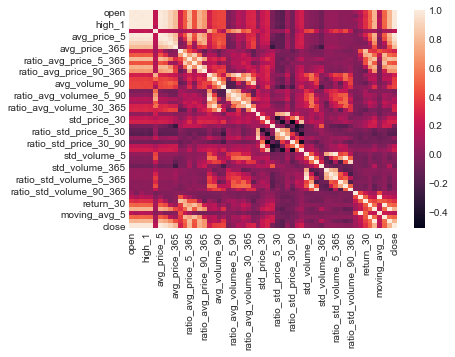

In [27]:
sns.heatmap(data.corr())

In [35]:
#import datetime module
import datetime

#segregate data for training
start_train = pd.to_datetime('2015-05-28').tz_localize('US/Eastern')
end_train = pd.to_datetime('2019-01-29').tz_localize('US/Eastern')
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,...,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,0.977569,0.977581,0.977639,0.98143,0.973798,96434.620767,0.977666,0.977763,0.977780,0.979761,...,0.899085,-0.000002,-0.000016,-0.000026,-0.000090,-0.003998,-0.000002,0.000004,-0.000007,0.977637
std,0.024720,0.024709,0.024697,0.02463,0.024808,24147.762768,0.024327,0.023283,0.020795,0.013575,...,0.200421,0.004754,0.010215,0.019451,0.028755,0.038206,0.002043,0.000454,0.000152,0.024699
min,0.913570,0.913570,0.912450,0.91532,0.909690,9100.949060,0.915672,0.923736,0.937074,0.956571,...,0.582774,-0.020818,-0.035021,-0.058300,-0.067139,-0.080319,-0.007098,-0.001093,-0.000314,0.912450
25%,0.958520,0.958540,0.958610,0.96280,0.954820,79109.000000,0.958540,0.959039,0.958471,0.966843,...,0.740077,-0.002819,-0.006496,-0.013776,-0.021141,-0.034973,-0.001288,-0.000323,-0.000131,0.958610
50%,0.980490,0.980490,0.980560,0.98398,0.977260,94624.000000,0.981062,0.980813,0.979873,0.980569,...,0.844409,0.000143,0.000080,-0.001121,-0.005065,-0.009482,0.000019,-0.000070,-0.000027,0.980560
75%,0.996050,0.996050,0.996000,0.99970,0.991400,108585.000000,0.995404,0.994354,0.992518,0.991985,...,1.062450,0.002847,0.006888,0.013209,0.020333,0.022051,0.001383,0.000332,0.000102,0.996000
max,1.033100,1.033100,1.033040,1.03980,1.028580,189858.677625,1.029526,1.020811,1.015612,1.002524,...,1.357328,0.017381,0.036956,0.058942,0.088081,0.093873,0.007299,0.001356,0.000370,1.033040


In [36]:
#segregate data for validation
start_test = pd.to_datetime('2019-01-30').tz_localize('US/Eastern')
end_test = pd.to_datetime('2020-03-15').tz_localize('US/Eastern')
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,...,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000
mean,0.914853,0.915133,0.914917,0.917923,0.912201,82186.874011,0.915366,0.917239,0.922099,0.938724,...,0.944131,-0.000299,-0.001093,-0.005298,-0.014483,-0.048975,-0.000218,-0.000227,-0.000192,0.914584
std,0.022145,0.022068,0.022108,0.021889,0.022303,29340.646326,0.021895,0.021513,0.021679,0.015332,...,0.215776,0.004221,0.008061,0.011285,0.016669,0.015122,0.001613,0.000269,0.000063,0.022264
min,0.868230,0.869100,0.868230,0.876550,0.864050,9100.949060,0.874324,0.883087,0.893730,0.910305,...,0.554733,-0.027977,-0.022562,-0.033578,-0.052684,-0.089123,-0.004553,-0.000854,-0.000361,0.855930
25%,0.898310,0.898460,0.898285,0.901045,0.895640,63390.000000,0.897720,0.900543,0.901075,0.925904,...,0.787101,-0.002786,-0.006488,-0.013179,-0.026520,-0.059691,-0.001294,-0.000421,-0.000236,0.898185
50%,0.907520,0.907520,0.907570,0.910580,0.905320,76744.000000,0.907196,0.906231,0.915341,0.938019,...,1.001888,-0.000601,-0.000946,-0.005646,-0.015473,-0.052659,-0.000180,-0.000239,-0.000207,0.907480
75%,0.937280,0.937650,0.937075,0.941215,0.934480,94523.500000,0.940552,0.942380,0.946857,0.953496,...,1.117297,0.001985,0.003974,0.002671,-0.001657,-0.038757,0.000796,-0.000018,-0.000149,0.936420
max,0.958890,0.958890,0.958880,0.961460,0.955920,189858.677625,0.957756,0.952369,0.957310,0.964703,...,1.341840,0.013065,0.036866,0.024725,0.030907,-0.009524,0.007279,0.000492,-0.000030,0.958880


In [37]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((953, 54), (291, 54), (953,), (291,))

In [ ]:
#SCALING THE PREDICTOR DATA

In [38]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
#LINEAR REGRESSION (LIN)

In [39]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.006
MAE: 0.004
R^2: 0.937


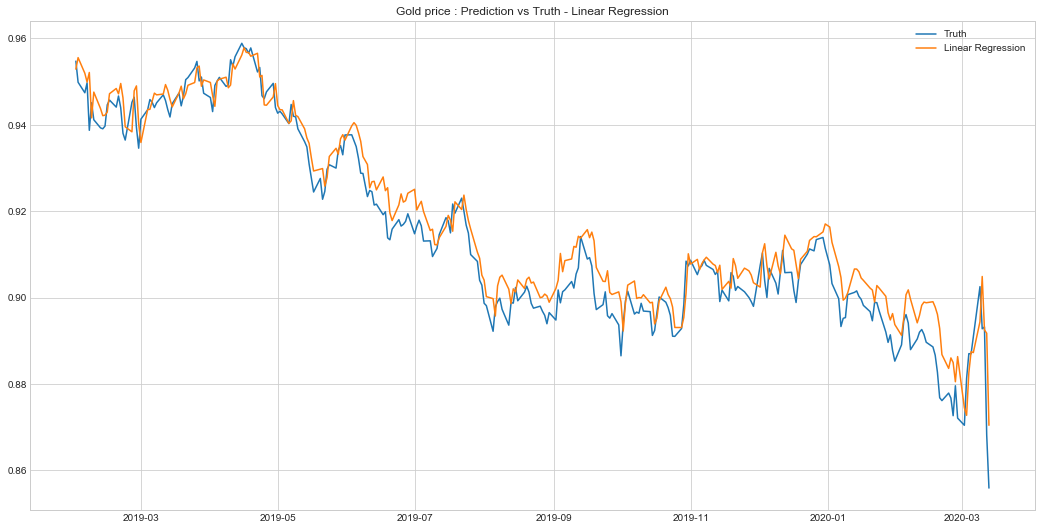

In [40]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

In [41]:
float(round((predictions_lin)[-1],5))


0.87046

In [42]:
float(y_test[-1])

0.85593

In [43]:
type(predictions_lin)

numpy.ndarray

In [ ]:
#SGD REGRESSOR (SGD)

In [44]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 0.006
MAE: 0.004
R^2: 0.938


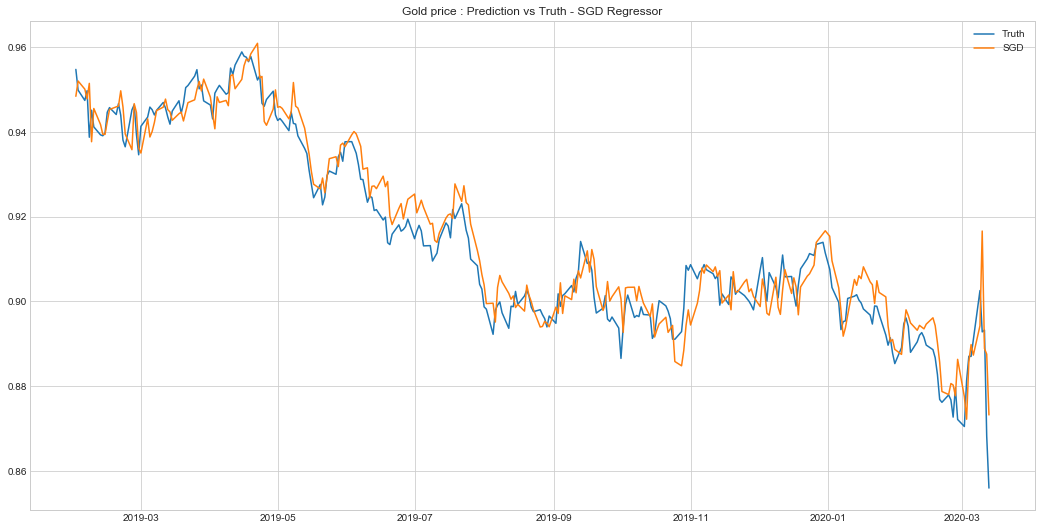

In [45]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

In [ ]:
#Extreme Gradient Boosting Regressor (XGB)

In [46]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    7.1s finished


[16:15:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.7}
[16:15:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.021
MAE: 0.016
R^2: 0.138


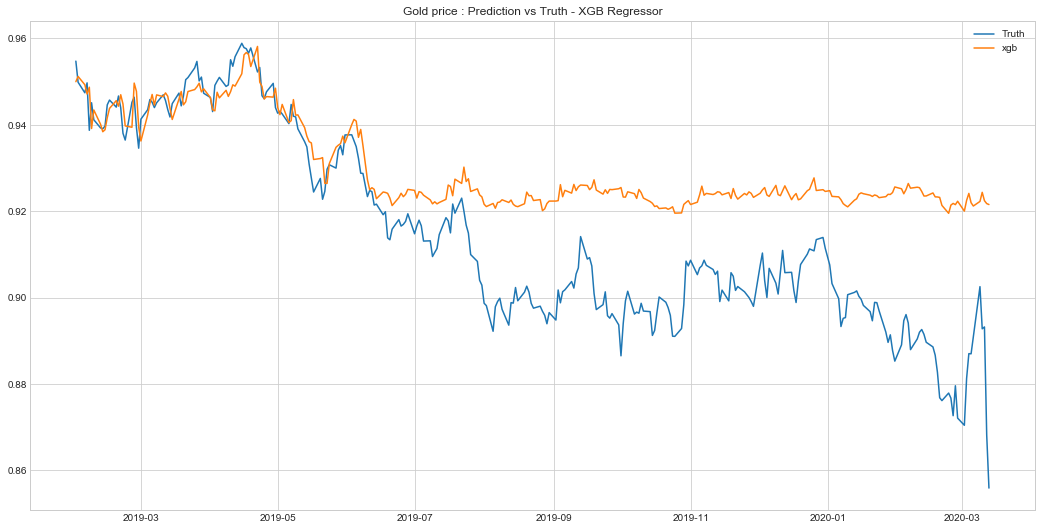

In [47]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

In [ ]:
#Bagging Regressor (BGR)

In [48]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.005
MAE: 0.004
R^2: 0.939


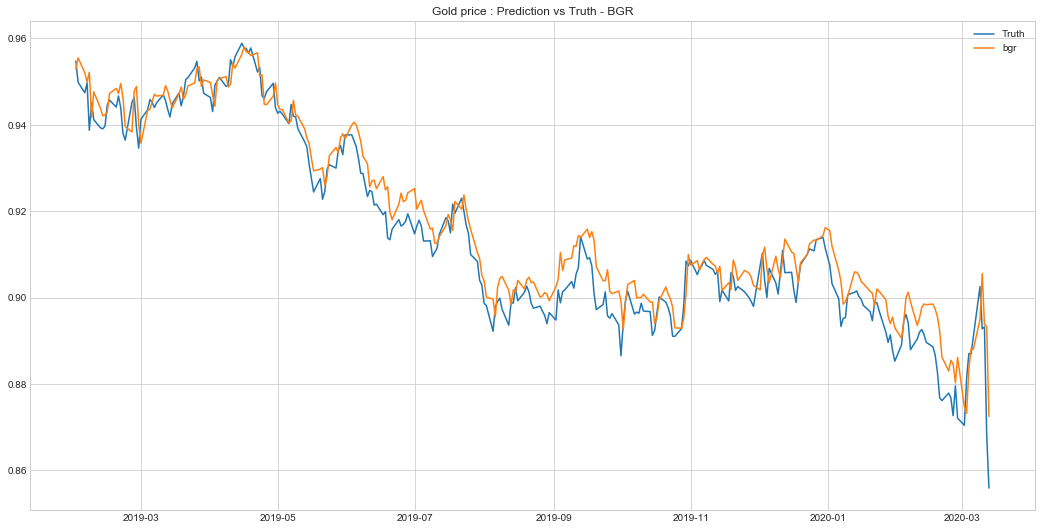

In [49]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

In [ ]:
#Random Forest Regressor (RF)

In [50]:
param_grid = {
    "max_depth": [50, 50],
    "min_samples_split": [5, 10, 15],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))

{'max_depth': 50, 'min_samples_split': 10}
RMSE: 0.021
MAE: 0.016
R^2: 0.131


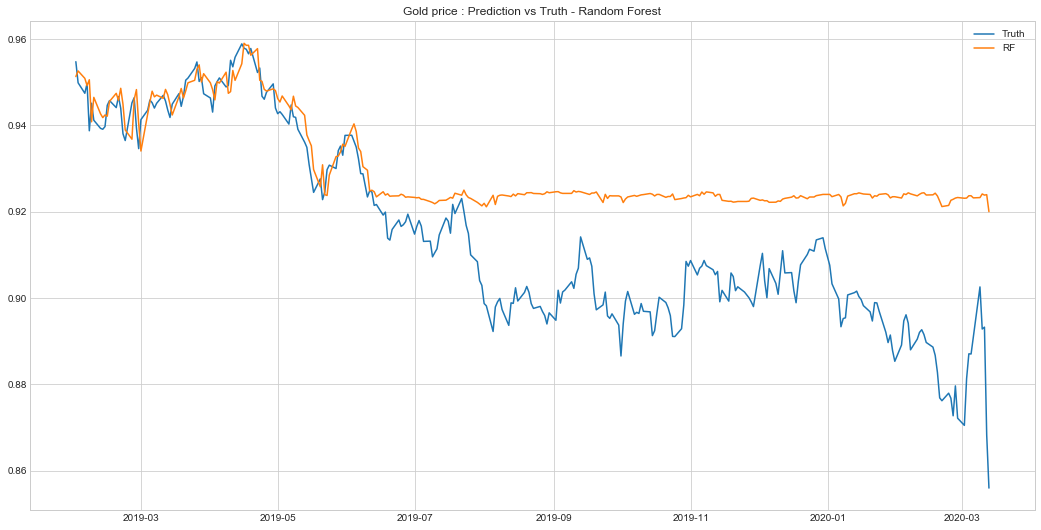

In [51]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

The model with the least mean_absolute_error:
 BGR    0.004326
dtype: float64


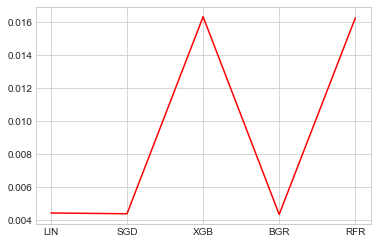

In [52]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')